### Connecting Pytorch Metal

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

### Loading the data

In [3]:
data = pd.read_table('../data/u.data')
data.head()

,user,event,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Pre-processing the data

In [4]:
users = data['user'].unique()
events = data['event'].unique()

events[:10], users[:10]

(array([242, 302, 377,  51, 346, 474, 265, 465, 451,  86]),
 array([196, 186,  22, 244, 166, 298, 115, 253, 305,   6]))

In [5]:
user_to_idx = {user: idx for idx, user in enumerate(users)}
event_to_idx = {event: idx for idx, event in enumerate(events)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()} # For reverse lookup
idx_to_event = {idx: event for event, idx in event_to_idx.items()} # For reverse lookup

for key, value in user_to_idx.items():
    if value == 0:
        print(f'User: {key}, assigned index: {value}')

for key, value in event_to_idx.items():
    if value == 0:
        print(f'Event: {key}, assigned index: {value}')

User: 196, assigned index: 0
Event: 242, assigned index: 0


In [6]:
data['user_idx'] = data['user'].map(user_to_idx)
data['event_idx'] = data['event'].map(event_to_idx)

data.head()

,user,event,rating,timestamp,user_idx,event_idx
0,196,242,3,881250949,0,0
1,186,302,3,891717742,1,1
2,22,377,1,878887116,2,2
3,244,51,2,880606923,3,3
4,166,346,1,886397596,4,4


In [7]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=21, shuffle=True)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=21, shuffle=True)
len(train_data), len(val_data), len(test_data)

(60000, 20000, 20000)

In [8]:
train_dataloader = DataLoader(train_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data[['user_idx', 'event_idx', 'rating']].values, batch_size=64, shuffle=False)

In [9]:
for batch in train_dataloader:
    print('Example batch: ', batch[:10])
    print()
    print('Len of a batch: ', len(batch))
    break

Example batch:  tensor([[ 467,  693,    3],
        [ 790, 1276,    4],
        [ 899,  647,    4],
        [  12,  157,    4],
        [ 907,  133,    5],
        [ 409,   51,    3],
        [ 353,  577,    3],
        [ 751,  582,    4],
        [ 741,  161,    4],
        [ 494,  191,    5]])

Len of a batch:  64


### CNN Feature Extractor

In [10]:
class CNN_FeatureExtractor(nn.Module):
    def __init__(self, input_channels,embedding_dim, output_dim):
        super(CNN_FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        # print(f"CNN input shape: {x.shape}")
        x = F.relu(self.conv1(x))
        # print(f"After conv1: {x.shape}")
        # x = self.pool(x)
        # print(f"After pool1: {x.shape}")
        x = F.relu(self.conv2(x))
        # print(f"After conv2: {x.shape}")
        x = self.pool(x)
        # print(f"After pool2: {x.shape}")
        x = x.view(x.size(0), -1)
        # print(f"After flatten: {x.shape}")
        x = self.fc(x)
        # print(f"CNN output shape: {x.shape}")
        return x

### NCF with CNN

In [11]:
class NCF_with_CNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=96, hidden_dim=64, cnn_output_dim=32, dropout_rate=0.5):
        super(NCF_with_CNN, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.user_cnn = CNN_FeatureExtractor(1, embedding_dim, cnn_output_dim)
        self.item_cnn = CNN_FeatureExtractor(1, embedding_dim, cnn_output_dim)
        
        self.fc1 = nn.Linear(cnn_output_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        user_features = self.user_cnn(user_emb.unsqueeze(1))
        item_features = self.item_cnn(item_emb.unsqueeze(1))
        
        x = torch.cat([user_features, item_features], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
num_users = len(users)
num_items = len(events)
embedding_dim = 96
cnn_output_dim = 32
hidden_dim = 64
model = NCF_with_CNN(num_users, num_items, cnn_output_dim=cnn_output_dim).to(device)
num_epochs = 10
lr = 1e-3
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

criterion = nn.MSELoss()
early_stopper = EarlyStopper(patience=3, min_delta=10)

/opt/anaconda3/envs/pytorch_metal/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
def calculate_metrics(predictions, targets):
    mae = nn.L1Loss()(predictions, targets).item()
    mse = nn.MSELoss()(predictions, targets).item()
    rmse = np.sqrt(mse)
    return mae, rmse


### Training

In [16]:
def train(model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, device, num_epochs=30):
    model.train()
    train_losses, val_losses = [], []
    train_maes, val_maes = [], []
    train_rmses, val_rmses = [], []
    
    for epoch in range(num_epochs):
        total_loss, total_mae, total_rmse = 0, 0, 0
        model.train()

        for batch in train_dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            optimizer.zero_grad()
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            mae, rmse = calculate_metrics(output, target)
            total_mae += mae
            total_rmse += rmse

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_mae = total_mae / len(train_dataloader)
        avg_train_rmse = total_rmse / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_maes.append(avg_train_mae)
        train_rmses.append(avg_train_rmse)

        # Validation phase
        model.eval()
        val_loss, val_mae, val_rmse = 0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
                output = model(user, event).squeeze()
                val_loss += criterion(output, target).item()
                mae, rmse = calculate_metrics(output, target)
                val_mae += mae
                val_rmse += rmse

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_mae = val_mae / len(val_dataloader)
        avg_val_rmse = val_rmse / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_maes.append(avg_val_mae)
        val_rmses.append(avg_val_rmse)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        print(f'Epoch: {epoch+1}/{num_epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}, Train RMSE: {avg_train_rmse:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}, Val RMSE: {avg_val_rmse:.4f}')

    return train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses



In [17]:
train_losses, val_losses, train_maes, val_maes, train_rmses, val_rmses = train(
    model, train_dataloader, val_dataloader, optimizer, scheduler, criterion, device, num_epochs=30
)

Epoch: 1/30, Train Loss: 1.9254, Train MAE: 1.1057, Train RMSE: 1.3466, Val Loss: 1.1460, Val MAE: 0.8773, Val RMSE: 1.0678
Epoch: 2/30, Train Loss: 1.3793, Train MAE: 0.9467, Train RMSE: 1.1700, Val Loss: 0.9779, Val MAE: 0.8018, Val RMSE: 0.9861
Epoch: 3/30, Train Loss: 1.2136, Train MAE: 0.8828, Train RMSE: 1.0976, Val Loss: 0.9071, Val MAE: 0.7564, Val RMSE: 0.9486
Epoch: 4/30, Train Loss: 1.1185, Train MAE: 0.8448, Train RMSE: 1.0537, Val Loss: 0.9204, Val MAE: 0.7512, Val RMSE: 0.9551
Epoch: 5/30, Train Loss: 1.0444, Train MAE: 0.8178, Train RMSE: 1.0182, Val Loss: 0.9037, Val MAE: 0.7569, Val RMSE: 0.9470
Epoch: 6/30, Train Loss: 0.9971, Train MAE: 0.7984, Train RMSE: 0.9943, Val Loss: 0.9123, Val MAE: 0.7659, Val RMSE: 0.9516
Epoch: 7/30, Train Loss: 0.9672, Train MAE: 0.7851, Train RMSE: 0.9793, Val Loss: 0.9102, Val MAE: 0.7657, Val RMSE: 0.9506
Epoch: 8/30, Train Loss: 0.9510, Train MAE: 0.7780, Train RMSE: 0.9711, Val Loss: 0.9118, Val MAE: 0.7503, Val RMSE: 0.9506
Epoch: 9

### Plotting

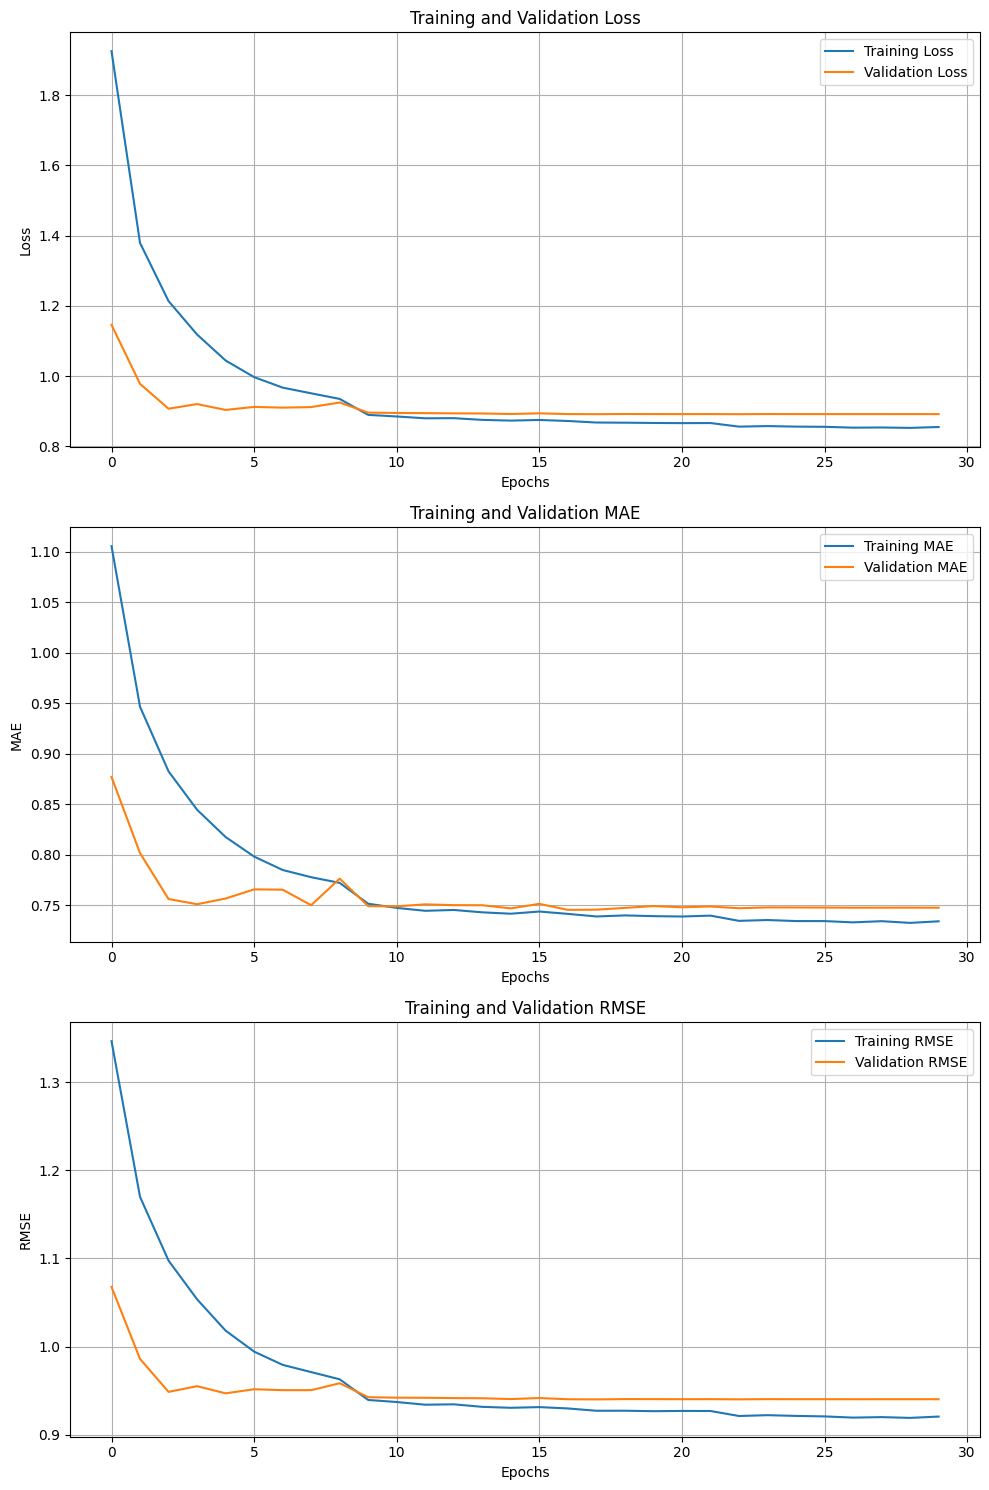

In [18]:
# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Loss plot
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# MAE plot
ax2.plot(train_maes, label='Training MAE')
ax2.plot(val_maes, label='Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')
ax2.set_title('Training and Validation MAE')
ax2.legend()
ax2.grid(True)

# RMSE plot
ax3.plot(train_rmses, label='Training RMSE')
ax3.plot(val_rmses, label='Validation RMSE')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSE')
ax3.set_title('Training and Validation RMSE')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

In [19]:
sample = [808, 881]
user = torch.tensor([user_to_idx[sample[0]]]).to(device)
event = torch.tensor([event_to_idx[sample[1]]]).to(device)
model.eval()
model(user, event)

tensor([[3.6600]], device='mps:0', grad_fn=<LinearBackward0>)

In [20]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            user, event, target = batch[:, 0].to(device), batch[:, 1].to(device), batch[:, 2].float().to(device)
            output = model(user, event).squeeze()
            loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [21]:
evaluate(model, test_dataloader, device)

0.8875870243809856